In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

import pandas as pd
import scipy
from sklearn import *
import re
from SimpleCountVectorizer import *
from TFIDFVectorizer import *

from nltk.stem import WordNetLemmatizer, SnowballStemmer

import xgboost as xgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/anaconda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/anaconda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
"""Given an int32 number, print it in English."""
def int_to_en(num):
    d = { 0 : 'zero', 1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
          6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten',
          11 : 'eleven', 12 : 'twelve', 13 : 'thirteen', 14 : 'fourteen',
          15 : 'fifteen', 16 : 'sixteen', 17 : 'seventeen', 18 : 'eighteen',
          19 : 'nineteen', 20 : 'twenty',
          30 : 'thirty', 40 : 'forty', 50 : 'fifty', 60 : 'sixty',
          70 : 'seventy', 80 : 'eighty', 90 : 'ninety' }
    k = 1000
    m = k * 1000
    b = m * 1000
    t = b * 1000

    assert(0 <= num)

    if (num < 20):
        return d[num]

    if (num < 100):
        if num % 10 == 0: return d[num]
        else: return d[num // 10 * 10] + '-' + d[num % 10]

    if (num < k):
        if num % 100 == 0: return d[num // 100] + ' hundred'
        else: return d[num // 100] + ' hundred and ' + int_to_en(num % 100)

    if (num < m):
        if num % k == 0: return int_to_en(num // k) + ' thousand'
        else: return int_to_en(num // k) + ' thousand, ' + int_to_en(num % k)

    if (num < b):
        if (num % m) == 0: return int_to_en(num // m) + ' million'
        else: return int_to_en(num // m) + ' million, ' + int_to_en(num % m)

    if (num < t):
        if (num % b) == 0: return int_to_en(num // b) + ' billion'
        else: return int_to_en(num // b) + ' billion, ' + int_to_en(num % b)

    if (num % t == 0): return int_to_en(num // t) + ' trillion'
    else: return int_to_en(num // t) + ' trillion, ' + int_to_en(num % t)

    raise AssertionError('num is too large: %s' % str(num))

# Count Vectorizer

In [3]:
train_df = pd.read_csv("./data/quora_train_data.csv")
test_df = pd.read_csv('./data/quora_test_data.csv')

# train_df, test_df = sklearn.model_selection.train_test_split(train_df, test_size=0.1, random_state=123)

In [4]:
train_df.shape, test_df.shape

((323432, 6), (80858, 6))

In [5]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    
    # return list(map(lambda x: str(x), all_questions)) # Slower
    return [str(s) for s in mylist]

In [6]:
all_questions = cast_list_as_strings(list(train_df.loc[:, 'question1'])+list(train_df.loc[:, 'question2']))
print(set(type(x).__name__ for x in all_questions))

{'str'}


In [7]:
def num_conv(s):
    try:
        return int_to_en(int(s)).replace(",","").replace(" ","_")
    except:
        return s


def my_doc_cleaner(doc,
                  pat=r"[^a-zA-Z0-9]"):
    # Allow alphanumeric characters
    doc_cleaner_pattern=pat
    clean_doc_pattern = re.compile(doc_cleaner_pattern)
    doc_clean = clean_doc_pattern.sub(" ", doc)
    return doc.lower()


# stpw = set(stopwords.words("english"))
stpw = []

stemmer =  SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def my_tokenizer_func(doc, 
                      ngrams=(1,3), 
                      numbers_to_words=True,
                      stop_words=stpw,
                      pat=r"(?u)\b\w\S*\w*\b",
                      lem=True,
                      stem=True):
    
    # Split using a patterm
#     pat=r"(?u)\b\w\w+\b"
#     pat=r"(?u)\b\w\S*\w*\b"
    token_pattern = re.compile(pat)
    lst = token_pattern.findall(doc)
    
    # Transform numbers into words
    if numbers_to_words:
        lst = list(map(lambda x: num_conv(x), lst))
        
    # Drop stopwords 
    lst = list(filter(lambda x : x not in stop_words, lst))
    
    #Stemmer
    if stem:
        lst = list(map(lambda x: stemmer.stem(x), lst))
    
    #Lemmatizer 
    if lem:
        lst = list(map(lambda x: lemmatizer.lemmatize(x), lst))
        
    if ngrams==(1,1):
        return lst
    
    # Generate ngrams
    lstRet = []
    for a in range(ngrams[0], ngrams[1]+1):
        if a!=1:
            lstRet+=list(zip(*[lst[i:] for i in range(a)]))
    return lstRet if ngrams[0]!=1 else lst+lstRet

In [8]:
count_vect = SimpleCountVectorizer(
    doc_cleaner_func=my_doc_cleaner,
    tokenizer_func=my_tokenizer_func
)
count_vect.fit(all_questions)

SimpleCountVectorizer(doc_cleaner_func=<function my_doc_cleaner at 0x7f32e7679268>,
                      doc_cleaner_pattern='[^a-zA-Z]',
                      dtype=<class 'numpy.float32'>, min_word_counts=1,
                      token_pattern='(?u)\\b\\w\\w+\\b',
                      tokenizer_func=<function my_tokenizer_func at 0x7f32e76792f0>,
                      word_transformer_func=None)

In [9]:
def get_features_from_df(df, vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
    
    q1 = vectorizer.transform(q1_casted)
    q2 = vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [10]:
%time X_tr_q1q2 = get_features_from_df(train_df,count_vect)
%time X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, train_df.shape, test_df.shape, X_te_q1q2.shape

CPU times: user 2min 50s, sys: 928 ms, total: 2min 50s
Wall time: 2min 47s
CPU times: user 42.7 s, sys: 140 ms, total: 42.8 s
Wall time: 41.1 s


((323432, 6166022), (323432, 6), (80858, 6), (80858, 6166022))

In [11]:
y_train = train_df["is_duplicate"].values
y_test = test_df['is_duplicate'].values

## Linear Regression

In [12]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=100)
logistic.fit(X_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [13]:
logistic.score(X_tr_q1q2, y_train), logistic.score(X_te_q1q2, y_test)

(0.9963670879813995, 0.8084914294194762)

## XGBoost

In [14]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# # PARAM GRID
# param_grid = {}
# param_grid['objective'] = 'binary:logistic'
# param_grid['eval_metric'] = ['auc', 'logloss']   #error: (wrong cases)/#(all cases)
# param_grid['eta'] = 0.02
# param_grid['max_depth'] = 10
# param_grid['n_estimators'] = 300

# d_train = xgb.DMatrix(X_tr_q1q2, label=y_train)  # For sparse matrices
# d_valid = xgb.DMatrix(X_te_q1q2, label=y_test)

# watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# bst = xgb.train(param_grid, d_train, 300, watchlist, early_stopping_rounds=10, verbose_eval=5, )
# #300 # train-auc:0.818362	train-logloss:0.527855	valid-auc:0.801083	valid-logloss:0.53815

In [15]:
import xgboost as xgb

N = 10000 # With early stopping
xgb_model = xgb.XGBClassifier(n_estimators=N)
xgb_model.fit(X_tr_q1q2, y_train, 
              verbose=10, 
              eval_set=[(X_tr_q1q2, y_train),(X_te_q1q2, y_test)], 
              early_stopping_rounds =10,
              eval_metric=['auc','logloss'],
              )

[0]	validation_0-auc:0.61862	validation_0-logloss:0.66116	validation_1-auc:0.61829	validation_1-logloss:0.66139
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[10]	validation_0-auc:0.74911	validation_0-logloss:0.58040	validation_1-auc:0.74669	validation_1-logloss:0.58202
[20]	validation_0-auc:0.77399	validation_0-logloss:0.55800	validation_1-auc:0.76904	validation_1-logloss:0.56121
[30]	validation_0-auc:0.79009	validation_0-logloss:0.54251	validation_1-auc:0.78377	validation_1-logloss:0.54671
[40]	validation_0-auc:0.80018	validation_0-logloss:0.53168	validation_1-auc:0.79315	validation_1-logloss:0.53663
[50]	validation_0-auc:0.81140	validation_0-logloss:0.52094	validation_1-auc:0.80380	validation_1-logloss:0.52644
[60]	validation_0-auc:0.81732	validation_0-logloss:0.51410	validation_1-auc:0.80909	validation_1-logloss:0.52034
[70]	validation_0-auc:0.82280	validation_0-lo

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

## Plot

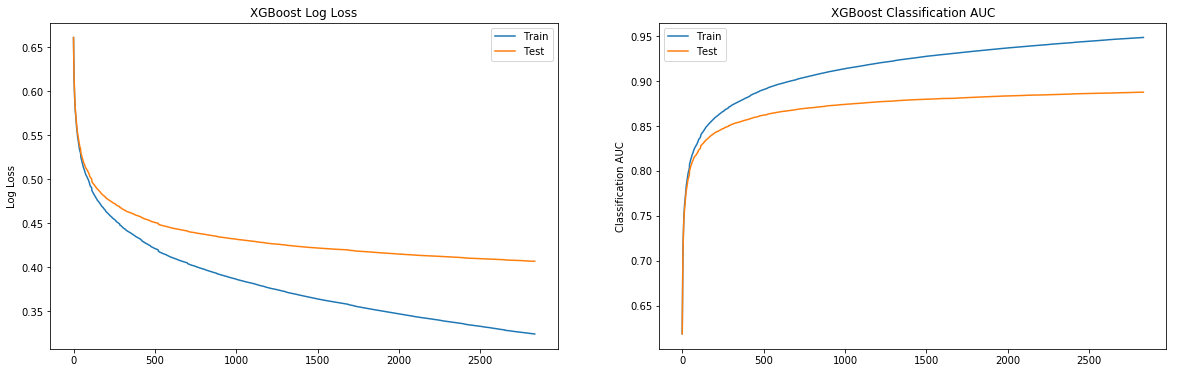

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig = plt.figure(figsize=(20,6))

# plot log loss
ax = fig.add_subplot(121)
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
ax.set_ylabel('Log Loss')
ax.set_title('XGBoost Log Loss')

# plot classification AUC
ax = fig.add_subplot(122)
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
ax.set_ylabel('Classification AUC')
ax.set_title('XGBoost Classification AUC')
plt.show()

### Save the model

In [17]:
from datetime import datetime

In [18]:
xgb_model.save_model('models/model_{}.dat'.format(datetime.now().strftime("%d.%m_%H.%M")))

### GridSearch

In [66]:
# from sklearn.model_selection import GridSearchCV

# parameters = {'nthread':[4], 
#               'objective':['binary:logistic'],
#               'learning_rate': [0.1,0.5,1], 
#               'max_depth': [3,5],
#               'scale_pos_weight':[1,5,20],
#               'min_child_weight': [4,5],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7, 0.9],
#               'n_estimators': [50]}

# N = 100
# xgb_model = xgb.XGBClassifier(n_estimators=N)
# grid = GridSearchCV(xgb_model, parameters,
#                     n_jobs = 5, scoring='roc_auc',
#                     verbose=True)
# grid.fit(X_tr_q1q2, y_train)

### Mistakes

In [22]:
def get_mistakes(clf, X_q1q2, y):

    predictions = np.around(clf.predict(X_q1q2)).astype(int)   
#     print(y[:10])
#     print(predictions[:10])
    incorrect_predictions = predictions!=y
#     print(incorrect_predictions[:10])
#     print(np.where(incorrect_predictions)[:10])
    incorrect_indices = np.where(incorrect_predictions)[0]
    
    if np.sum(incorrect_predictions)==0:
        print("no mistakes in this df")
    else:
        return incorrect_indices, predictions
    
def print_mistake_k(k, mistake_indices, predictions, df):
    print(df.iloc[mistake_indices[k]].question1)
    print(df.iloc[mistake_indices[k]].question2)
    print("true class:", df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    
def print_mistake_k_and_tokens(k, mistake_indices, predictions,
                               X_q1q2, count_vect, clf, df):
    q1 = df.iloc[mistake_indices[k]].question1
    q2 = df.iloc[mistake_indices[k]].question2
    
    print(q1)
    print(count_vect.tokenize(q1))
    print()
    print(q2)
    print(count_vect.tokenize(q2))
    print()
    print("true class:", df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    print()
    print("Probability vector: [P(0|x), P(1|x)]:")
    print(clf.predict_proba(X_q1q2)[mistake_indices[k],:])
    
    
def hist_errors(mistake_indices, predictions,
                               X_q1q2, count_vect, clf, df):
    qs = df.iloc[mistake_indices][['question1', 'question2']]
    qs['true_class']=df.iloc[mistake_indices].is_duplicate
    qs['prediction']=predictions[mistake_indices]
    qs['P(1|x)']=clf.predict_proba(X_q1q2)[mistake_indices,:][:,1]
    qs = qs.reset_index(drop=True)
    return qs


In [24]:
mistake_indices, predictions = get_mistakes(xgb_model, X_te_q1q2, y_test)

### Load the model

In [19]:
bst = xgb.Booster({'nthread': 4})  # init booster
bst.load_model('models/model_29.03_21.26.dat')  # load data

In [20]:
xgb_loaded_model = xgb.XGBClassifier()
xgb_loaded_model._Booster=bst

In [25]:
mistake_indices, predictions = get_mistakes(xgb_loaded_model, X_te_q1q2, y_test)

/opt/anaconda/lib/python3.6/site-packages/xgboost/sklearn.py:901: UserWarning: Label encoder is not defined.  Returning class probability.
  'Label encoder is not defined.  Returning class probability.')


In [26]:
len(mistake_indices)

15342

In [27]:
print_mistake_k(0, mistake_indices, predictions, test_df)

Which book is the best for GRE preparation?
Which are the best books for the IELTS and the GRE preparation?
true class: 0
prediction: 1


In [28]:
print_mistake_k_and_tokens(0, mistake_indices, predictions,
                           X_te_q1q2, count_vect, xgb_loaded_model, test_df)

Which book is the best for GRE preparation?
['which', 'book', 'is', 'the', 'best', 'for', 'gre', 'prepar', ('which', 'book'), ('book', 'is'), ('is', 'the'), ('the', 'best'), ('best', 'for'), ('for', 'gre'), ('gre', 'prepar'), ('which', 'book', 'is'), ('book', 'is', 'the'), ('is', 'the', 'best'), ('the', 'best', 'for'), ('best', 'for', 'gre'), ('for', 'gre', 'prepar')]

Which are the best books for the IELTS and the GRE preparation?
['which', 'are', 'the', 'best', 'book', 'for', 'the', 'ielt', 'and', 'the', 'gre', 'prepar', ('which', 'are'), ('are', 'the'), ('the', 'best'), ('best', 'book'), ('book', 'for'), ('for', 'the'), ('the', 'ielt'), ('ielt', 'and'), ('and', 'the'), ('the', 'gre'), ('gre', 'prepar'), ('which', 'are', 'the'), ('are', 'the', 'best'), ('the', 'best', 'book'), ('best', 'book', 'for'), ('book', 'for', 'the'), ('for', 'the', 'ielt'), ('the', 'ielt', 'and'), ('ielt', 'and', 'the'), ('and', 'the', 'gre'), ('the', 'gre', 'prepar')]

true class: 0
prediction: 1

Probabilit

In [29]:
qs = hist_errors(mistake_indices, predictions,
                           X_te_q1q2, count_vect, xgb_loaded_model, test_df)

In [30]:
N = 20

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', N)
pd.set_option('display.max_colwidth', -1)

In [31]:
# Read mistakes
qs = pd.read_csv("mistakes.csv")
qs.head(N)

,question1,question2,true_class,prediction,P(1|x)
0,Which book is the best for GRE preparation?,Which are the best books for the IELTS and the GRE preparation?,0,1,0.681601
1,How can an Indian student get into Harvard Medical School for their undergrad?,What do I need to do to get into Harvard Medical School?,0,1,0.652885
2,What is the purpose of solubility tests?,Why do you do the solubility test?,1,0,0.028398
3,Why am I getting my period so much?,Why am I getting my period twice a month?,0,1,0.532057
4,How can I recover an iPhone 5 deleted text conversation?,How do I retrieve my deleted SMS from iPhone 6?,1,0,0.274019
5,Is there any way to adjust title and font default settings in Google docs?,How can I change the default font in Google docs?,1,0,0.087301
6,How many articles does the Constitution have?,How many articles and chapter are their in our Indian constitution?,1,0,0.148157
7,How can I prepare for a technical and hr interview?,How do I prepare for my hr interview?,1,0,0.457206
8,Is LinkedIn a good acquisition for Microsoft?,"Will Microsoft's acquisition of LinkedIn prove useful for Microsoft? If so, what will 'useful' look like?",1,0,0.306823
9,Does Hillary Clinton have any serious health issues?,Does Hillary Clinton have any known health issues that might keep her from running or succeeding in 2016?,1,0,0.449223


# TFIDF

In [25]:
tfidf_vectorizer = TFIDFVectorizer(count_vect.vocabulary, count_vect.word_to_ind, count_vect.tokenize)
tfidf_vectorizer.fit(all_questions)

TFIDF fit finished in 181.48 seconds


In [26]:
X_tfidf_tr_q1q2 = get_features_from_df(train_df, tfidf_vectorizer)
X_tfidf_te_q1q2  = get_features_from_df(test_df, tfidf_vectorizer)

X_tfidf_tr_q1q2.shape, train_df.shape, test_df.shape, X_tfidf_te_q1q2.shape

TFIDF transform finished in 91.75 seconds
TFIDF transform finished in 93.02 seconds
TFIDF transform finished in 22.81 seconds
TFIDF transform finished in 23.93 seconds


((323432, 6166022), (323432, 6), (80858, 6), (80858, 6166022))

In [27]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=100)
logistic.fit(X_tfidf_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [28]:
logistic.score(X_tfidf_tr_q1q2, y_train), logistic.score(X_tfidf_te_q1q2, y_test)

(0.9006499047713276, 0.7898167157238616)

In [29]:
mistake_indices, predictions = get_mistakes(logistic, X_tfidf_te_q1q2, y_test)

In [30]:
print_mistake_k(0, mistake_indices, predictions)

How do I study for Honeywell company recruitment?
How do I study for Honeywell company recruitments?
true class: 1
prediction: 0


In [31]:
print_mistake_k_and_tokens(0, mistake_indices, predictions,
                           X_tfidf_te_q1q2, tfidf_vectorizer, logistic)

How do I study for Honeywell company recruitment?
['how', 'do', 'i', 'studi', 'for', 'honeywel', 'compani', 'recruit', ('how', 'do'), ('do', 'i'), ('i', 'studi'), ('studi', 'for'), ('for', 'honeywel'), ('honeywel', 'compani'), ('compani', 'recruit'), ('how', 'do', 'i'), ('do', 'i', 'studi'), ('i', 'studi', 'for'), ('studi', 'for', 'honeywel'), ('for', 'honeywel', 'compani'), ('honeywel', 'compani', 'recruit')]

How do I study for Honeywell company recruitments?
['how', 'do', 'i', 'studi', 'for', 'honeywel', 'compani', 'recruit', ('how', 'do'), ('do', 'i'), ('i', 'studi'), ('studi', 'for'), ('for', 'honeywel'), ('honeywel', 'compani'), ('compani', 'recruit'), ('how', 'do', 'i'), ('do', 'i', 'studi'), ('i', 'studi', 'for'), ('studi', 'for', 'honeywel'), ('for', 'honeywel', 'compani'), ('honeywel', 'compani', 'recruit')]

true class: 1
prediction: 0

Probability vector: [P(0|x), P(1|x)]:
[0.73466044 0.26533956]


In [32]:
######### SEARCH QUESTIONS WITH SAME TOKENS ###########

q1_casted =  cast_list_as_strings(list(train_df["question1"]))
q2_casted =  cast_list_as_strings(list(train_df["question2"]))

q1 = count_vect.transform(q1_casted)
q2 = count_vect.transform(q2_casted)

same_tokens_idxs = []
for i in range(len(q1_casted)):
    same_features = ( q1[i] != q2[i] ).nnz == 0
    if same_features:
        same_tokens_idxs.append(i)
    if i % 500 == 0: print(i)

same_tokens_idxs = np.array(same_tokens_idxs)


same_tokens = train_df.iloc[same_tokens_idxs]
duplicates = same_tokens['is_duplicate'] == 1

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

,id,qid1,qid2,question1,question2,is_duplicate
154,3148,6241,6242,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
170,15678,29935,29936,How can I make money as a 13 year old?,How can I make money as a thirteen year old?,0
246,403514,253677,537096,What are the most haunted places in delhi?,What are the most haunted place in delhi?,0
1723,290549,26661,70364,What language is used in Visual Basic? How doe...,What language is used in Visual Basic? How doe...,0
2145,184520,281899,281900,What are the best things about modeling?,What are the best things about models?,0
...,...,...,...,...,...,...
316104,45535,81584,81585,What is the definition of blog?,What is the definition of blogging?,0
316373,288872,294219,122887,What is the difference between : and ; ?,"What is the difference between "":="" and ""::="" ?",0
317754,248848,285169,362342,What does this symbol mean?,What does this '≜' symbol mean?,0
318279,102122,169021,169022,What is refrigerant?,What is refrigeration?,0


In [33]:
same_tokens[duplicates]

,id,qid1,qid2,question1,question2,is_duplicate
1,327668,454117,345117,How do I study for Honeywell company recruitment?,How do I study for Honeywell company recruitme...,1
163,251786,317853,86925,How do I get permanent residence in New Zealand?,How do I get permanent residency in New Zealand?,1
873,351007,479805,479806,What is Open source technology?,What is open source technologies?,1
1644,383603,474670,70140,Who will be the next president of US ?,Who will be the next president of US?,1
1857,346791,421809,140365,What are some examples of vertebrated animals?,What are some examples of vertebrate animals?,1
...,...,...,...,...,...,...
322629,302747,425769,425770,How is the word 'servile' used in a sentence?,"How is the word ""servile"" used in a sentence?",1
322814,272376,390622,390623,Is there any good reading room available near ...,Is there any good reading room available near ...,1
322882,115624,188516,188517,Two hot copper and steel balls long sitting in...,Two hot copper and steel balls long sitting in...,1
323043,256986,372216,372217,Do virus and Bacteria have souls?,Do viruses and bacteria have souls?,1


In [34]:
same_tokens[~duplicates]

,id,qid1,qid2,question1,question2,is_duplicate
154,3148,6241,6242,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
170,15678,29935,29936,How can I make money as a 13 year old?,How can I make money as a thirteen year old?,0
246,403514,253677,537096,What are the most haunted places in delhi?,What are the most haunted place in delhi?,0
1723,290549,26661,70364,What language is used in Visual Basic? How doe...,What language is used in Visual Basic? How doe...,0
2145,184520,281899,281900,What are the best things about modeling?,What are the best things about models?,0
...,...,...,...,...,...,...
316104,45535,81584,81585,What is the definition of blog?,What is the definition of blogging?,0
316373,288872,294219,122887,What is the difference between : and ; ?,"What is the difference between "":="" and ""::="" ?",0
317754,248848,285169,362342,What does this symbol mean?,What does this '≜' symbol mean?,0
318279,102122,169021,169022,What is refrigerant?,What is refrigeration?,0
